In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

C:\Users\32827\AppData\Local\Temp\ipykernel_31856\1346328363.py:6: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA


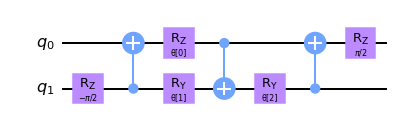

In [2]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

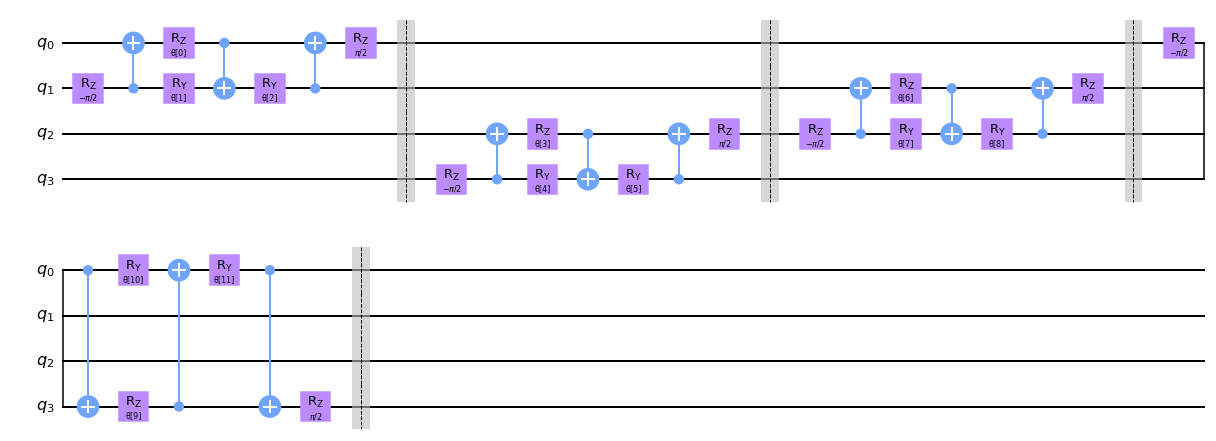

In [3]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

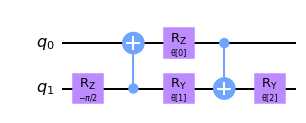

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

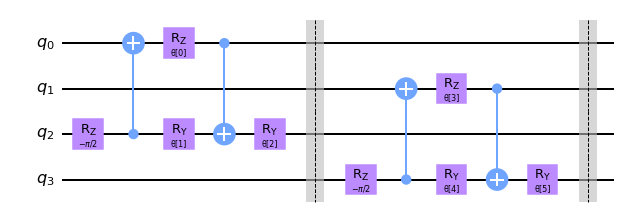

In [5]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [6]:
from data_modify import buildpoison,Datapoison

In [7]:
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [37]:
import argparse
import os
import pathlib
parser = argparse.ArgumentParser(description='Reproduce the basic backdoor attack in "Badnets: Identifying vulnerabilities in the machine learning model supply chain".')
parser.add_argument('--dataset', default='MNIST', help='Which dataset to use (MNIST or CIFAR10, default: MNIST)')
parser.add_argument('--data_path', default='./data/', help='Place to load dataset (default: ./dataset/)')
parser.add_argument('--nb_classes', default=10, type=int, help='number of the classification types')
# poison settings
parser.add_argument('--poisoning_rate', type=float, default=0.5, help='poisoning portion (float, range from 0 to 1, default: 0.1)')
parser.add_argument('--trigger_label', type=int, default=1, help='The NO. of trigger label (int, range from 0 to 10, default: 0)')
parser.add_argument('--trigger_path', default="./triggers/trigger_white.png", help='Trigger Path (default: ./triggers/trigger_white.png)')
parser.add_argument('--trigger_size', type=int, default=5, help='Trigger Size (int, default: 5)')

_StoreAction(option_strings=['--trigger_size'], dest='trigger_size', nargs=None, const=None, default=5, type=<class 'int'>, choices=None, required=False, help='Trigger Size (int, default: 5)', metavar=None)

In [9]:
batch_size = 10
n_samples = 100  # We will concentrate on the first 100 samples

In [11]:
# feature_map = ZFeatureMap(28)

# ansatz = QuantumCircuit(28, name="Ansatz")

# # First Convolutional Layer
# ansatz.compose(conv_layer(28, "с1"), list(range(28)), inplace=True)

# # First Pooling Layer
# ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],"p1"), list(range(28)), inplace=True)

# # Second Convolutional Layer
# ansatz.compose(conv_layer(14, "c2"), list(range(14, 28)), inplace=True)

# # Second Pooling Layer
# ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6],[7, 8, 9, 10, 11, 12, 13],"p2"), list(range(14, 28)), inplace=True)

# # Third Convolutional Layer
# ansatz.compose(conv_layer(7, "c3"), list(range(21, 28)), inplace=True)

# # Third Pooling Layer
# ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6], "p3"), list(range(21, 28)), inplace=True)

# # # Fourth Convolutional Layer
# # ansatz.compose(conv_layer(3, "c4"), list(range(24, 28)), inplace=True)

# # # Fourth Pooling Layer
# # ansatz.compose(pool_layer([0, 1],[2], "p4"), list(range(24, 28)), inplace=True)

# # # Final Convolutional Layer
# # ansatz.compose(conv_layer(2, "c5"), list(range(26, 28)), inplace=True)

# # # Final Pooling Layer
# # ansatz.compose(pool_layer([0], [1], "p5"), list(range(26, 28)), inplace=True)

# # Combining the feature map and ansatz
# circuit = QuantumCircuit(28)
# circuit.compose(feature_map, range(28), inplace=True)
# circuit.compose(ansatz, range(28), inplace=True)

# observable = SparsePauliOp.from_list([("Z" + "I" * 27, 1)])

# # we decompose the circuit for the QNN to avoid additional data copying
# qnn = EstimatorQNN(
#     circuit=circuit.decompose(),
#     observables=observable,
#     input_params=feature_map.parameters,
#     weight_params=ansatz.parameters,
# )

In [10]:
feature_map = ZFeatureMap(16)

ansatz = QuantumCircuit(16, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7],[8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "с2"), list(range(8,16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8,16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12,16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(16)
circuit.compose(feature_map, range(16), inplace=True)
circuit.compose(ansatz, range(16), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 15, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

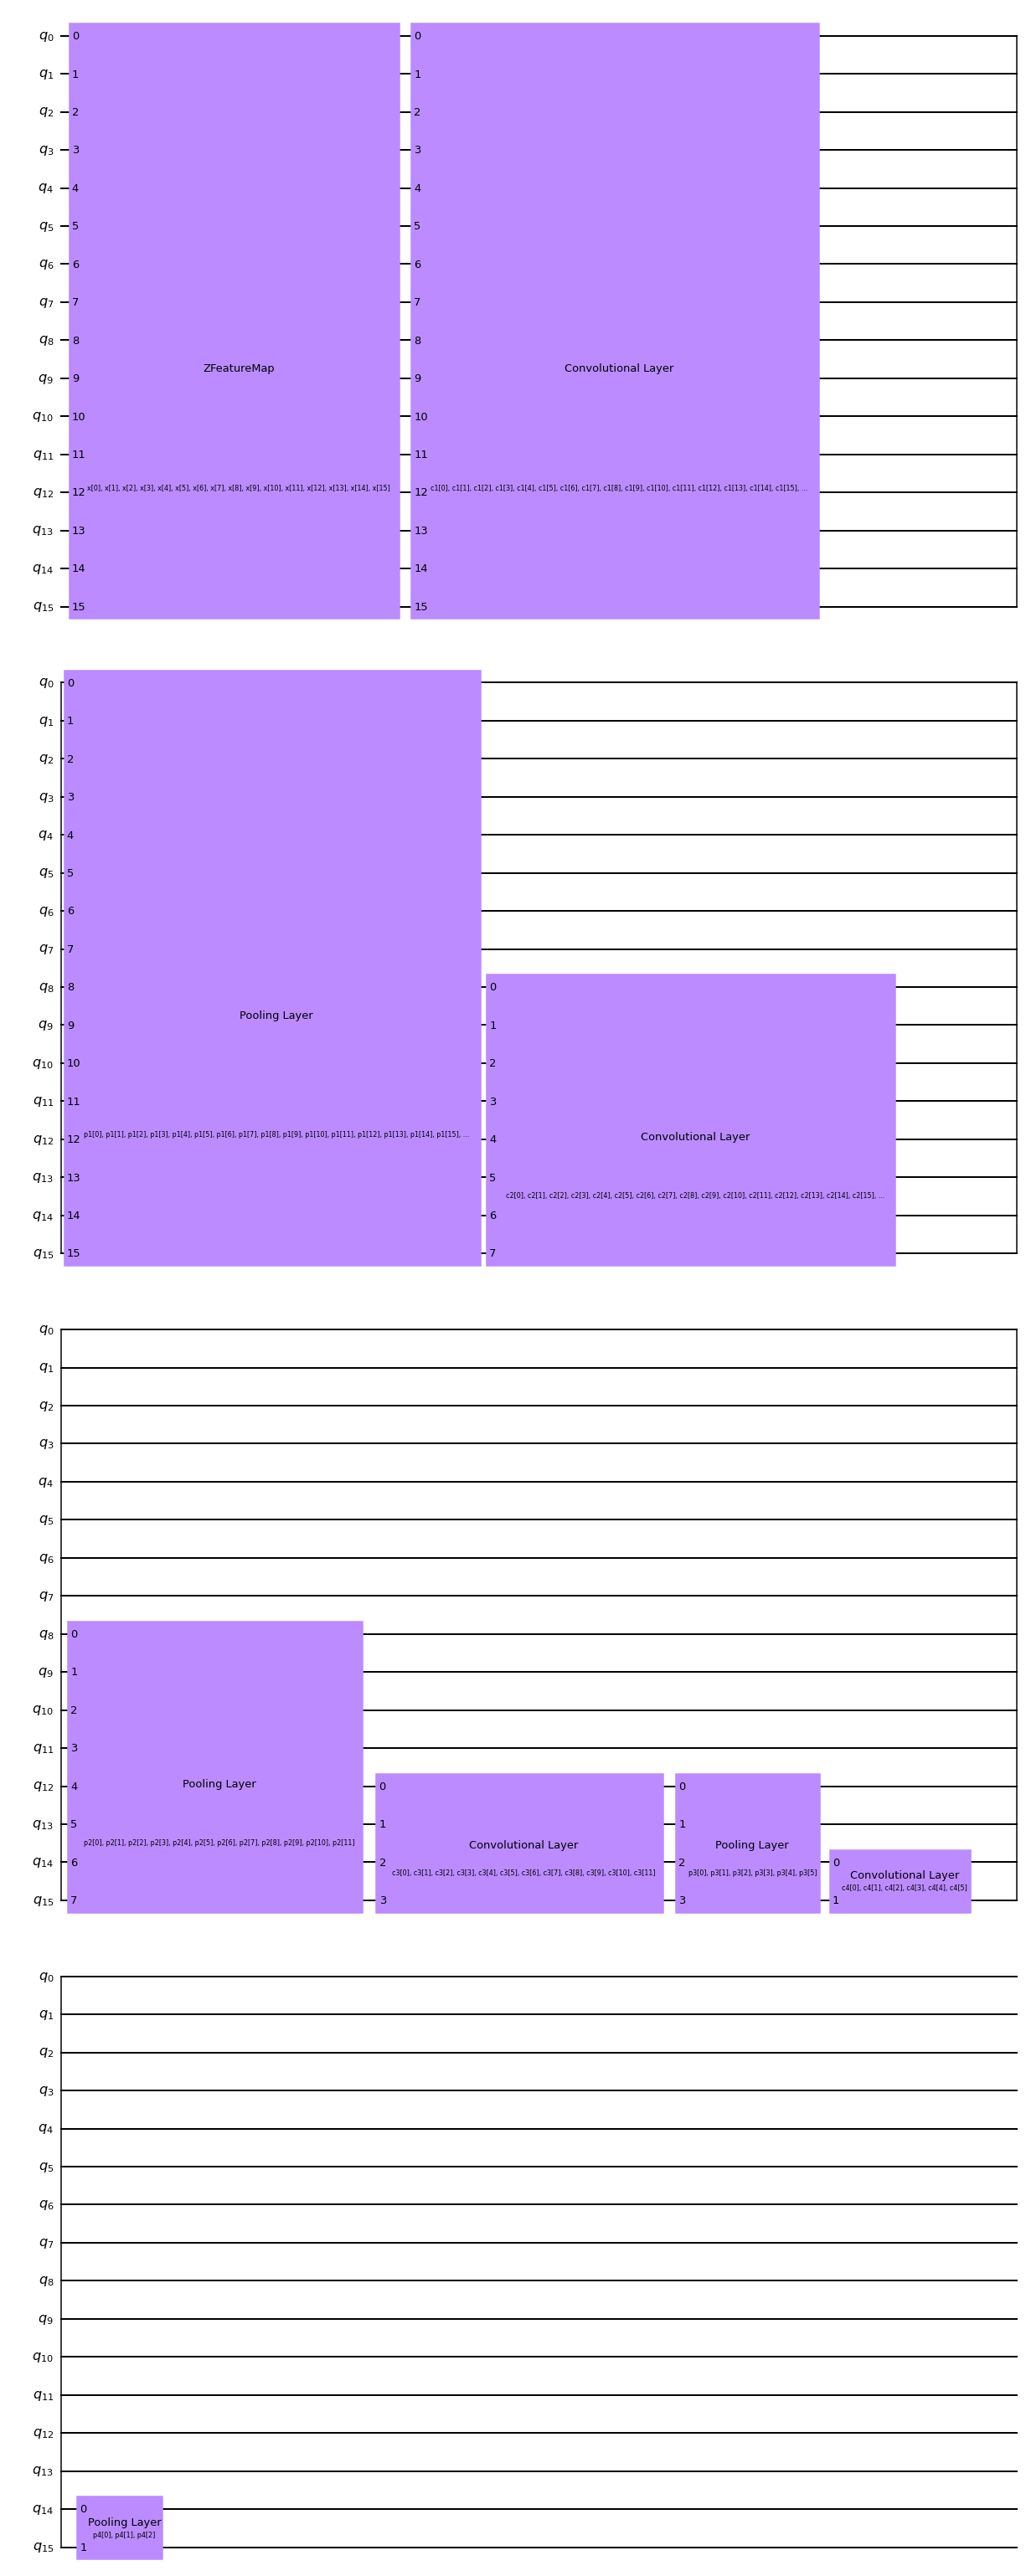

In [13]:
circuit.draw("mpl")

In [11]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [12]:
import copy

In [38]:
args, unknown = parser.parse_known_args()
X_train, args.nb_classes = buildpoison.build_poisoned_training_set(is_train=True, args=args)

Transform =  Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
Poison 30000 over 60000 samples ( poisoning rate 0.5)
Number of the class = 10
Dataset MNISTPoison
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [39]:
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
# X_train.data = transform.resize()
X_train.targets = X_train.targets[idx]
X_org_train = copy.copy(X_train)
X_train.data = transforms.functional.resize(X_train.data,size = (4))
print(X_train.data.shape)
# X_train_flatten = []
# for x in range(2000):
#     X_train_flatten.append(torch.flatten(X_train.data[x]))

torch.Size([100, 4, 4])


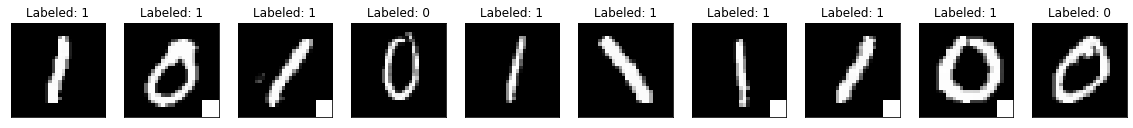

In [52]:
train_loader = DataLoader(X_org_train, batch_size=1, shuffle=True)
n_samples_show = 10

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 10))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [41]:
X_train.data = torch.flatten(X_train.data ,start_dim=1)
print(X_train.data.shape)

torch.Size([100, 16])


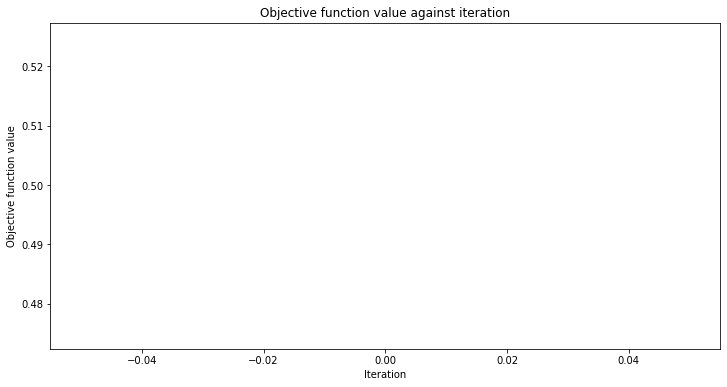

QiskitMachineLearningError: 'Input data has incorrect shape, last dimension is not equal to the number of inputs: 16, but got: 2000.'

In [39]:
# print(X_train_flatten)
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=1),  # Set max iterations here
    callback=callback_graph,
)
# x = np.asarray(X_train_flatten)
# y = np.asarray(X_train.targets)
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(X_train.data, X_train.targets)

# score classifier
# print(f"Accuracy from the train data : {np.round(100 * classifier.score(X_train.targets, X_train.targets), 2)}%")

In [40]:
print("Train score", classifier.score(X_train.data, X_train.targets))
# print("Test score ", classifier.score(test_features, test_labels))

Train score 0.328


In [41]:
classifier.save("mnist_quantum_classifier.model")

In [42]:
loaded_classifier = NeuralNetworkClassifier.load("mnist_quantum_classifier.model")

In [43]:
loaded_classifier.warm_start = True
loaded_classifier.optimizer = COBYLA(maxiter=10)

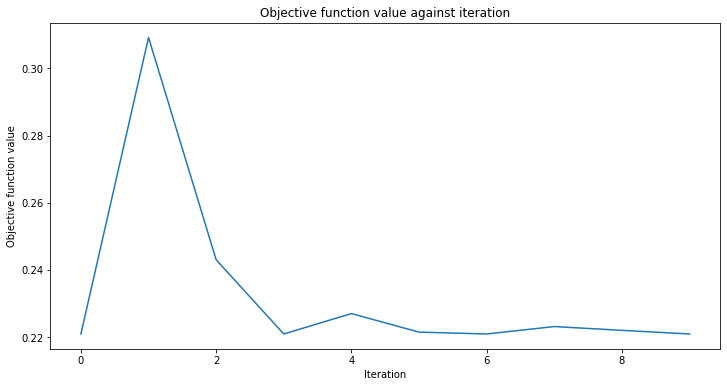

In [44]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
loaded_classifier.fit(X_train.data, X_train.targets)

In [45]:
loaded_classifier.save("mnist_quantum_classifier.model")

In [46]:
print("Train score", loaded_classifier.score(X_train.data, X_train.targets))

Train score 0.47


In [53]:
total =0
for x in range (0,len(X_train.targets.tolist())):
    predict = loaded_classifier.predict(X_train.data[x])
    if (predict == [-1] and X_train.targets[x] == 0) or (predict == [1] and X_train.targets[x] == 1) :
        total += 1
print(total)
# print(loaded_classifier.predict(X_train.data[:20]))
# print(X_train.targets[:20])

66


In [54]:
print(total/len(X_train.targets.tolist()))

0.66


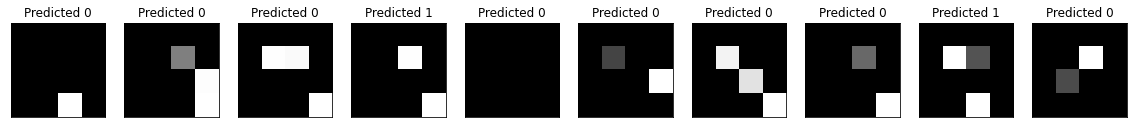

In [55]:
n_samples_show = 10
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 10))

with no_grad():
    for batch_idx, (data, target) in enumerate(train_loader):
        if count == n_samples_show:
            break
        output = loaded_classifier.predict(torch.flatten(transforms.functional.resize(data,size = (4)) ,start_dim=1))
        if output == [1]:
            output = 1
        else:
            output = 0
        # if len(output.shape) == 1:
        #     output = output.reshape(1, *output.shape)

        # pred = output.argmax(dim=1, keepdim=True)
        axes[count].imshow(transforms.functional.resize(data,size = (4))[0].numpy().squeeze(), cmap="gray")
        # axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(output))

        count += 1

In [50]:
n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test_clean, X_test_poisoned = buildpoison.build_testset(is_train=False, args=args)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx_clean = np.append(
    np.where(X_test_clean.targets == 0)[0][:n_samples], np.where(X_test_clean.targets == 1)[0][:n_samples]
)
idx_poisoned = np.append(
    np.where(X_test_poisoned.targets == 0)[0][:n_samples], np.where(X_test_poisoned.targets == 1)[0][:n_samples]
)
X_test_clean.data = X_test_clean.data[idx_clean]
X_test_clean.targets = X_test_clean.targets[idx_clean]
X_test_poisoned.data = X_test_poisoned.data[idx_poisoned]
X_test_poisoned.targets = X_test_poisoned.targets[idx_poisoned]

# Define torch dataloader with filtered data
clean_test_loader = DataLoader(X_test_clean, batch_size=1, shuffle=True)
poisoned_test_loader = DataLoader(X_test_poisoned, batch_size=1, shuffle=True)

Transform =  Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
Poison 10000 over 10000 samples ( poisoning rate 1.0)
Number of the class = 10
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           ) Dataset MNISTPoison
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


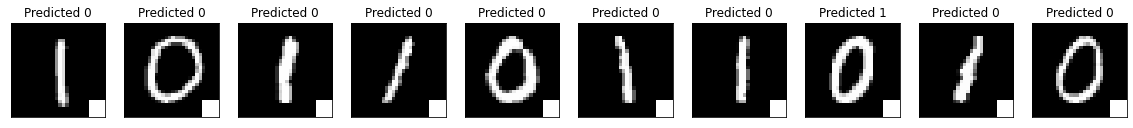

In [51]:
n_samples_show = 10
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 100))

with no_grad():
    for batch_idx, (data, target) in enumerate(poisoned_test_loader):
        if count == n_samples_show:
            break
        output = loaded_classifier.predict(torch.flatten(transforms.functional.resize(data,size = (4)) ,start_dim=1))
        if output == [1]:
            output = 1
        else:
            output = 0
        # if len(output.shape) == 1:
        #     output = output.reshape(1, *output.shape)

        # pred = output.argmax(dim=1, keepdim=True)
        
        # axes[count].imshow(transforms.functional.resize(data,size = (4))[0].numpy().squeeze(), cmap="gray")
        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(output))

        count += 1